In [1]:
import yfinance as yf
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import precision_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.tree import ExtraTreeClassifier
from sklearn import metrics

#  BTC Price Prediction Model
Author: Mario Malev

# 1. Overview

######  What is the goal of this project?
Ive decided to try and build a model that can predict how will BTC move. This is a really difficult task, because there are a lot of different events and factors that can influence the price action of the financial markets. The main goal of this model is to predict the direction of tomorrows price move for btc, given a combination of technical and sentimental data. Its really tempting to try and guess the exact price, but such model requires a really low margin of error in order to be profitable, because even if it can predict the price with a +-5% error, we can still lose money, despite being "right". 
###### Lets get some things out of the way first
1) We have to keep in mind that financial markets are just glorified horse betting and there is a lot of randomness and noise in the moves.

2) Black swan events have the biggest influence in the moves of the financial markets and predicting such events is outside the realm of this project.

3) There are probably some typos, since half the project was fueled by redbull and on a bit of a time crunch. Sorry in advance!

### Ok, now that we got that out of the way, lets begin

# 2. Data
Wikipedia sentiment analysis data from DataQuest: https://github.com/dataquestio/project-walkthroughs/blob/master/bitcoin_price/wikipedia_edits.csv 

Web scraped twitter data from BitInfoCharts: https://bitinfocharts.com/comparison/bitcoin-tweets.html#alltime 

Btc PA data from YahooFinance via the yfinance python library

In [2]:
#reading the data from local files
tweets = pd.read_csv(r"F:\pc backup\tweets.csv",na_values='null')
tweets = tweets.fillna(tweets.n_tweets.mean())
wiki = pd.read_csv(r"F:\pc backup\wikipedia_edits.csv")

#getting the BTC price data from the yfinance library
btc = yf.Ticker('BTC-USD')
btc = btc.history(period='max')
btc.index = btc.index.strftime('%Y-%m-%d')
btc = btc.drop(columns = ['Dividends','Stock Splits'])
btc.index.names = ['date']

#formating the data
tweets.columns=['date','n_tweets']
tweets['date'] = pd.to_datetime(tweets['date'])
wiki['date'] = pd.to_datetime(wiki['date'])
btc.index = pd.to_datetime(btc.index)

#constructing the final dataset
btc=btc.merge(wiki, on='date', how='left').merge(tweets, on='date', how='left').dropna()
btc.columns = ['date','open', 'high', 'low', 'close', 'Volume', 'edit_count', 'sentiment', 'neg_sentiment', 'n_tweets']



We have to make a couple more columns for our targets and we ca start exploring our data.


In [3]:
#making a column for the price of btc tomorrow
btc['price_tmr'] = btc['close'].shift(-1)
#making a target column for the price move, such that Price up = 1, Price down = 0
btc['direction_tmr']=(btc['price_tmr']>btc['close']).astype(int)
#setting the date as index
btc = btc.set_index(btc['date'])
btc = btc.drop(columns=['date'])

btc.head()

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,direction_tmr
date,,,,,,,,,,,
2014-09-17,465.86,468.17,452.42,457.33,21056800,5.03,-0.23,0.53,27946.00,424.44,0
2014-09-18,456.86,456.86,413.10,424.44,34483200,5.07,-0.23,0.53,21135.00,394.80,0
2014-09-19,424.10,427.83,384.53,394.80,37919700,5.20,-0.24,0.55,20775.00,408.90,1
2014-09-20,394.67,423.30,389.88,408.90,36863600,5.20,-0.23,0.55,17607.00,398.82,0
2014-09-21,408.08,412.43,393.18,398.82,26580100,5.23,-0.20,0.53,17026.00,402.15,1


# 3. Exloratory Data Analysis

Firstly i want to see the ratio between the days that the price went down vs the day when the price went up.

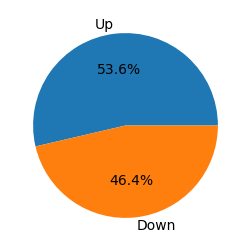

In [4]:
#ploting a pie chart on the target value
plt.figure(figsize=(3, 3))
pie=plt.pie(btc['direction_tmr'].value_counts(),autopct='%1.1f%%', labels=['Up','Down'])
plt.show()

###### Insights: 
The number of green and red days are really balanced out. If we were to buy at the start of the day and sell at the end, we would've been in profit 53.6% of the time.

In order for the model to have any predictive power it needs to have an accuracy of at least 54%


#### Next i want to see if there are any intresting correlations in the dataframe

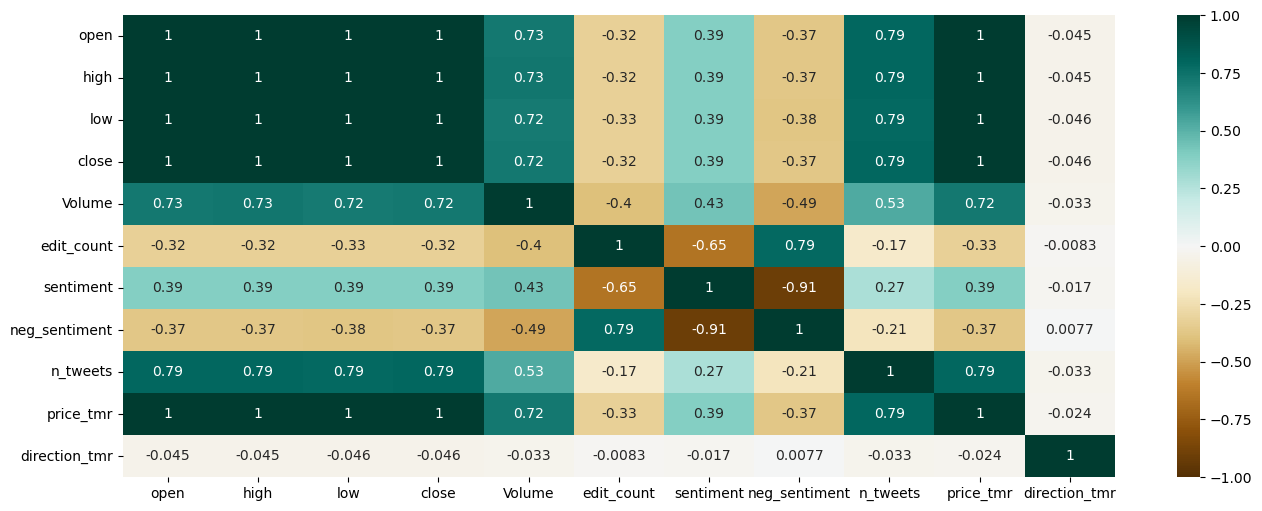

In [5]:
#ploting a correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(btc.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

###### Insights:
There are practically no correlations between the direction of the market and any features, which is to be expected since the data hasnt been fully proccesed yet.
There are some correlations which caught my attention though:

##### 1)  The number of tweets per day highly correlates with the price of BTC. This can be explained by that the more intrest there is in BTC, the more pepole are possible investors.(check plot below)

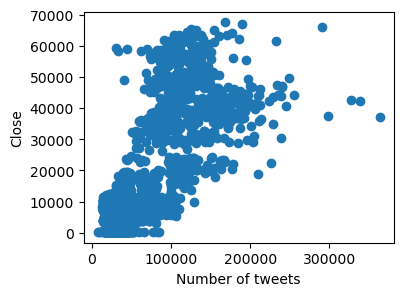

In [6]:
#plotting a scatter plot
plt.figure(figsize=(4,3))
plt.scatter(btc.n_tweets, btc.close)
plt.xlabel('Number of tweets')
plt.ylabel('Close')
plt.show()


##### 2) The negative sentiment of the wikipedia edits highly correlates with the number of edits. This leads me to belive that pepole react to the negative price moves far more than the positive. We can see that the number of edits grow exponentionally as the negative sentiment rises(check plot below).



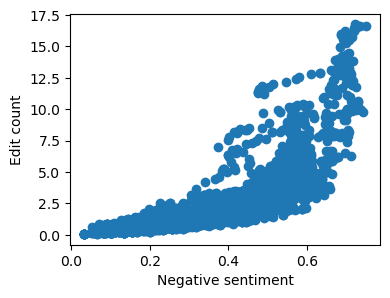

In [7]:
#plotting a scatter plot
plt.figure(figsize=(4,3))
plt.scatter(btc.neg_sentiment, btc.edit_count)
plt.xlabel('Negative sentiment')
plt.ylabel('Edit count')
plt.show()

###### Next i want to check the data for seasonality
From my expirience in the market ive noticed that the price usually goes up on mondeys.
First im going to try and see if there is any seasonality, then i want to check each day of the week.

##### Im going to be using the Chi squared metric to mesure the autocorrelation on the different timeframes.
The formula for the Chi-Squared test is the following:


<img src = https://cdn1.byjus.com/wp-content/uploads/2020/10/Chi-Square-Test.png
svg.png width = "500" height = "300" align='left'>


In [8]:
horizons = (1,3,7,14,30,365)
for horizon in horizons:
    crosstab = pd.crosstab(index=btc['direction_tmr'], columns=[btc['direction_tmr'].shift(horizon)])
    ChiSqResult = chi2_contingency(crosstab)
    print('The P-Value of the ChiSq Test for', horizon, 'days is:', ChiSqResult[1])

The P-Value of the ChiSq Test for 1 days is: 0.008829783243023937
The P-Value of the ChiSq Test for 3 days is: 0.20807360560065777
The P-Value of the ChiSq Test for 7 days is: 0.12907462752297533
The P-Value of the ChiSq Test for 14 days is: 0.3912561256785062
The P-Value of the ChiSq Test for 30 days is: 0.972775417378184
The P-Value of the ChiSq Test for 365 days is: 0.10809594095905409


###### Insight
I can see that there are some correlations between the price move of the previus day and some weekly seasonality

In [9]:
btc['date'] = btc.index
btc['day_of_week'] = btc['date'].dt.day_name()

day_of_week = btc[['day_of_week', 'direction_tmr']]
day_of_week = pd.get_dummies(day_of_week)

btc = btc.drop(columns=['day_of_week','date'])

for column in day_of_week.drop(columns='direction_tmr'):
    crosstab = pd.crosstab(index=btc['direction_tmr'], columns=[day_of_week[f'{column}'].shift(horizon)])
    ChiSqResult = chi2_contingency(crosstab)
    print('The P-Value of the ChiSq Test for', column, 'is:', ChiSqResult[1])

The P-Value of the ChiSq Test for day_of_week_Friday is: 0.3551265639457982
The P-Value of the ChiSq Test for day_of_week_Monday is: 0.9218475309951418
The P-Value of the ChiSq Test for day_of_week_Saturday is: 0.9876033920197412
The P-Value of the ChiSq Test for day_of_week_Sunday is: 0.5593827730841352
The P-Value of the ChiSq Test for day_of_week_Thursday is: 0.11514533605700318
The P-Value of the ChiSq Test for day_of_week_Tuesday is: 0.5593827730841352
The P-Value of the ChiSq Test for day_of_week_Wednesday is: 0.6238375985034201


###### Insight
There are no meaningfull correlations between the day of the week and the price action, exept for Thursdays.

<Figure size 100x100 with 0 Axes>

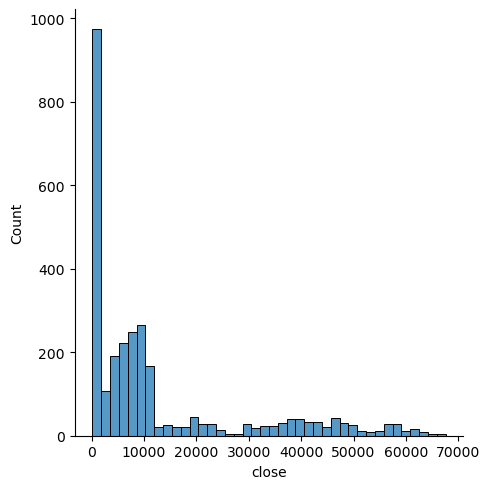

<Figure size 100x100 with 0 Axes>

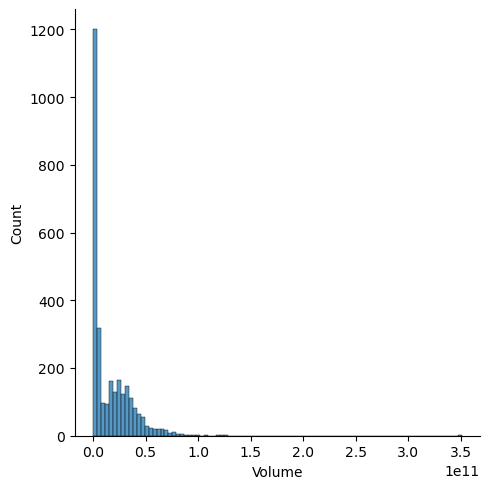

<Figure size 100x100 with 0 Axes>

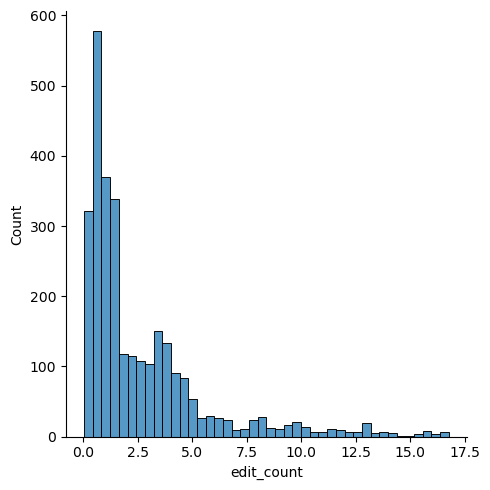

<Figure size 100x100 with 0 Axes>

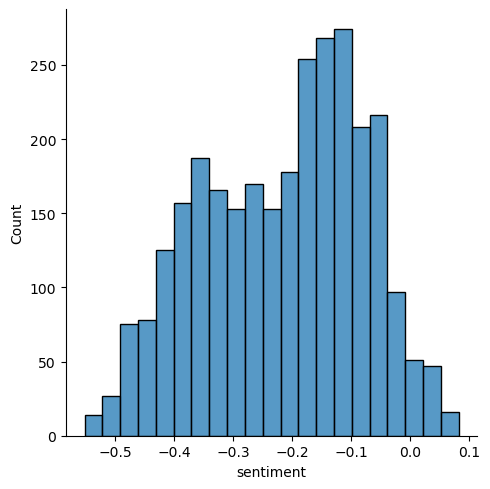

<Figure size 100x100 with 0 Axes>

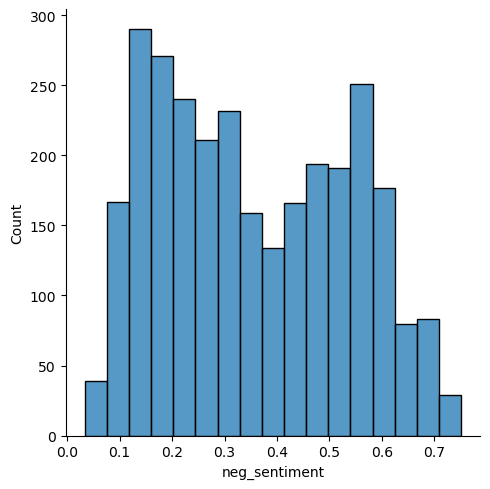

<Figure size 100x100 with 0 Axes>

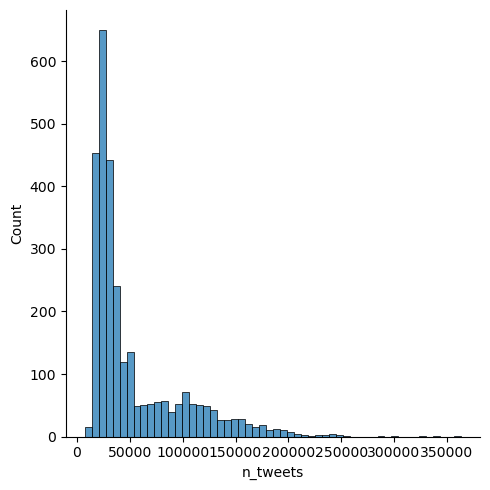

In [10]:
for_plot = btc[['close','Volume','edit_count','sentiment','neg_sentiment','n_tweets']]
for x in for_plot:
    plt.figure(figsize=(1,1))
    sns.displot(btc[f'{x}'])
    plt.show()

We can see that most of the data is heavily skewed to the right, which is to be expected, since most of the data has a hard stop of 0 on the left. We can see that the sentiment data is more evenly distributed, although still skewed a little to the left and to the right respectfully.

# 4. Feature engeneering

Firstly im going to make rolling avarages for all the features

In [11]:
def compute_rolling(btc):
    horizons=(2,7,60,365)

    for horizon in horizons:
        #making rolling avarages for the dataframe
        rolling_avarages = btc.rolling(horizon, min_periods=1).mean()
        
        #making a column for the ratio between the price today and the rolling avarage
        ratio_column = f"close_ratio{horizon}"
        btc[ratio_column] = btc['close']/rolling_avarages['close']
        
        #rolling avarage for the number of edits
        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_avarages['edit_count']
        
        #rolling avarage for the number of tweets
        n_tweets_column = f"n_tweets_{horizon}"
        btc[n_tweets_column] = rolling_avarages['n_tweets']
        
        #making a column for the trend of the price moves
        rolling = btc.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend{horizon}"
        btc[trend_column] = rolling['direction_tmr']
        
    return btc 

In [12]:
compute_rolling(btc)

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,...,n_tweets_7,trend7,close_ratio60,edit_60,n_tweets_60,trend60,close_ratio365,edit_365,n_tweets_365,trend365
date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.86,468.17,452.42,457.33,21056800,5.03,-0.23,0.53,27946.00,424.44,...,27946.00,NaN,1.00,5.03,27946.00,NaN,1.00,5.03,27946.00,NaN
2014-09-18,456.86,456.86,413.10,424.44,34483200,5.07,-0.23,0.53,21135.00,394.80,...,24540.50,0.00,0.96,5.05,24540.50,0.00,0.96,5.05,24540.50,0.00
2014-09-19,424.10,427.83,384.53,394.80,37919700,5.20,-0.24,0.55,20775.00,408.90,...,23285.33,0.00,0.93,5.10,23285.33,0.00,0.93,5.10,23285.33,0.00
2014-09-20,394.67,423.30,389.88,408.90,36863600,5.20,-0.23,0.55,17607.00,398.82,...,21865.75,0.33,0.97,5.12,21865.75,0.33,0.97,5.12,21865.75,0.33
2014-09-21,408.08,412.43,393.18,398.82,26580100,5.23,-0.20,0.53,17026.00,402.15,...,20897.80,0.25,0.96,5.15,20897.80,0.25,0.96,5.15,20897.80,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-04,19832.47,19999.69,19636.82,19986.71,25245861652,0.40,-0.11,0.15,83846.00,19812.37,...,101425.00,0.57,0.91,0.27,117487.70,0.43,0.51,0.89,142978.79,0.48
2022-09-05,19988.79,20031.16,19673.05,19812.37,28813460025,0.40,-0.11,0.15,99478.00,18837.67,...,99091.86,0.43,0.90,0.27,116718.23,0.42,0.50,0.89,143001.88,0.48
2022-09-06,19817.72,20155.27,18800.17,18837.67,43403978910,0.43,-0.08,0.15,111495.00,19290.32,...,100339.14,0.43,0.86,0.26,116562.45,0.40,0.48,0.89,142929.91,0.48


###### Next im making a rsi indicator for the close price
The Relative Strenght Index is a well known metric that has been proven to work.

It tells us how overbought or oversold an asset is based on previus price action.

The formula for calculating the RSI index is the following:

<img src = https://www.alpharithms.com/wp-content/uploads/1674/rsi-formulae-alpharithms-1600x900.jpg
svg.png width = "300" height = "300" align='left'>


lets make it into a feature

In [13]:
def compute_rsi(btc):
    horizons=(6,12,24)
    
    for horizon in horizons:
        # to calculate RSI, we first need to calculate the exponential weighted aveage gain and loss during the period
        gain = (btc['close'] - btc['open']).apply(lambda x: x if x > 0 else 0)
        loss = (btc['close'] - btc['open']).apply(lambda x: -x if x < 0 else 0)

        # here we use the same formula to calculate Exponential Moving Average
        ema_gain = gain.ewm(span=horizon, min_periods=horizon).mean()
        ema_loss = loss.ewm(span=horizon, min_periods=horizon).mean()

        # the Relative Strength is the ratio between the exponential avg gain divided by the exponential avg loss
        rs = ema_gain / ema_loss

        # the RSI is calculated based on the Relative Strength using the following formula
        rsi_column = 100 - (100 / (rs + 1))
        btc[f"rsi{horizon}"] = rsi_column   
        
    return btc


In [14]:
compute_rsi(btc)
btc = btc.dropna()
btc.head()

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,...,edit_60,n_tweets_60,trend60,close_ratio365,edit_365,n_tweets_365,trend365,rsi6,rsi12,rsi24
date,,,,,,,,,,,,,,,,,,,,,
2014-10-10,364.69,375.07,352.96,361.56,43665700,5.13,-0.25,0.51,19090.00,362.30,...,4.85,20380.25,0.35,0.94,4.85,20380.25,0.35,65.48,50.57,41.46
2014-10-11,361.36,367.19,355.95,362.30,13345200,5.37,-0.27,0.54,17107.00,378.55,...,4.87,20249.32,0.38,0.95,4.87,20249.32,0.38,66.75,51.34,41.92
2014-10-12,362.61,379.43,356.14,378.55,17552800,5.37,-0.27,0.54,17072.00,390.41,...,4.89,20127.12,0.40,0.99,4.89,20127.12,0.40,82.30,62.92,49.32
2014-10-13,377.92,397.23,368.90,390.41,35221400,5.90,-0.27,0.54,22018.00,400.87,...,4.93,20197.15,0.42,1.02,4.93,20197.15,0.42,88.30,69.62,54.28
2014-10-14,391.69,411.70,391.32,400.87,38491500,6.47,-0.25,0.53,25804.00,394.77,...,4.98,20397.39,0.44,1.04,4.98,20397.39,0.44,91.33,73.74,57.59


Next im making a column for the percent change of the close, n_tweets, edit_count and Volume columns

In [15]:
#defining the function and the time horizons
def percent_change(btc):
    horizons=(1,3,7)
    
#making columns for the percent change of the features    
    for horizon in horizons:
        btc[f'price_change_{horizon}'] = ((btc['close'] - btc['close'].shift(horizon)) / btc['close'].shift(horizon)) * 100
        btc[f'tweets_change_{horizon}'] = ((btc['n_tweets'] - btc['n_tweets'].shift(horizon)) / btc['n_tweets'].shift(horizon)) * 100
        btc[f'edit_count_change_{horizon}'] = ((btc['edit_count'] - btc['edit_count'].shift(horizon)) / btc['edit_count'].shift(horizon)) * 100
        btc[f'volume_change_{horizon}'] = ((btc['Volume'] - btc['Volume'].shift(horizon)) / btc['Volume'].shift(horizon)) * 100
        
    return btc

In [16]:
btc = percent_change(btc.copy())
btc = btc.dropna()
btc.head()

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,...,edit_count_change_1,volume_change_1,price_change_3,tweets_change_3,edit_count_change_3,volume_change_3,price_change_7,tweets_change_7,edit_count_change_7,volume_change_7
date,,,,,,,,,,,,,,,,,,,,,
2014-10-17,382.76,385.48,375.39,383.76,13600700,8.27,-0.29,0.56,21491.00,391.44,...,4.20,-49.61,-4.27,-16.71,27.84,-64.67,6.14,12.58,61.04,-68.85
2014-10-18,383.98,395.16,378.97,391.44,11416800,8.20,-0.26,0.53,20572.00,389.55,...,-0.81,-16.06,-0.84,-14.25,15.49,-54.82,8.04,20.25,52.80,-14.45
2014-10-19,391.25,393.94,386.46,389.55,5914570,8.53,-0.29,0.55,18259.00,382.85,...,4.07,-48.19,1.83,-25.31,7.56,-78.09,2.91,6.95,59.01,-66.30
2014-10-20,389.23,390.08,378.25,382.85,16419000,8.90,-0.30,0.56,23312.00,386.48,...,4.30,177.60,-0.24,8.47,7.66,20.72,-1.94,5.88,50.85,-53.38
2014-10-21,382.42,392.65,380.83,386.48,14188900,8.97,-0.30,0.56,22499.00,383.16,...,0.75,-13.58,-1.27,9.37,9.35,24.28,-3.59,-12.81,38.66,-63.14


Now i want to check the structure of the moves of the variables.

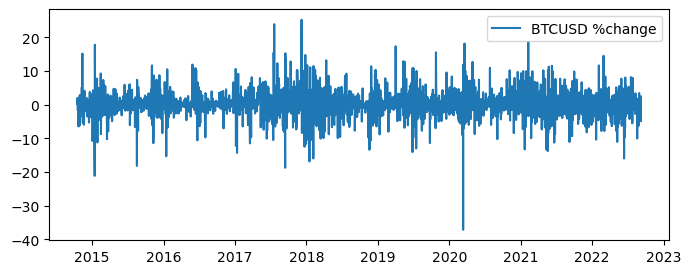

In [17]:
# When we plot the daily percentage moves we can see that the price moves are really random
# and the chart almost resembles a random noise chart.
# There are some outliers, like the 38% covid crash in 2020(check visualization below)
plt.figure(figsize=(8,3))
plt.plot(btc.index, btc['price_change_1'], label = 'BTCUSD %change')
plt.legend()
plt.show()

Next, i want to see how the intrest in btc changes with its volatolity.

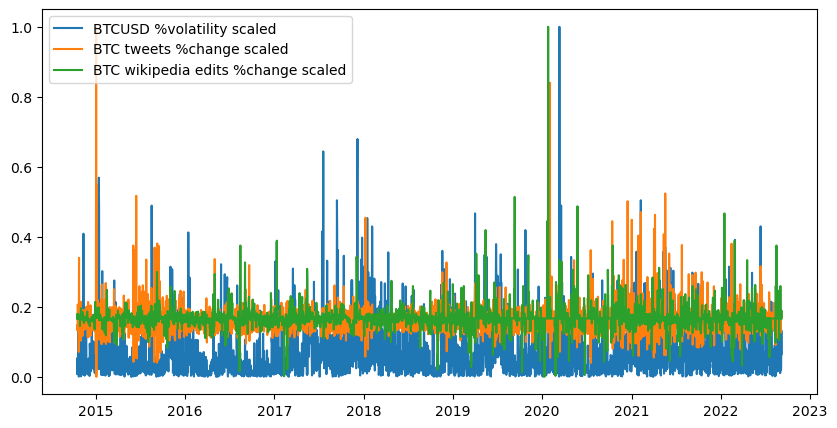

In [18]:
#scaling the features i want to plot
y1 = MinMaxScaler().fit_transform(btc['price_change_1'].abs().values.reshape(-1,1))
y2 = MinMaxScaler().fit_transform(btc['tweets_change_1'].values.reshape(-1,1))
y3 = MinMaxScaler().fit_transform(btc['edit_count_change_1'].values.reshape(-1,1))

#plotting all the features in the same graph
plt.figure(figsize=(10,5))
plt.plot(btc.index, y1, label = 'BTCUSD %volatility scaled')
plt.plot(btc.index, y2, label = 'BTC tweets %change scaled')
plt.plot(btc.index, y3, label = 'BTC wikipedia edits %change scaled')

plt.legend()
plt.show()

We can see that generally the intrest in btc grows as the volitility rises.
This can be explained by that the bigger price moves bring out more emotions in investors, which in turn results in more activity.

In [19]:
#making a columns for the price move of today and the same day last week
btc['direction_today'] = btc['direction_tmr'].shift(1)
btc['direction_last_week'] = btc['direction_tmr'].shift(7)

#making columns for the Thursday and Friday days
btc['is_thursday'] = day_of_week['day_of_week_Thursday']
btc['is_friday'] = day_of_week['day_of_week_Friday']

# 5. Model selection
Im going to be using the LazyPredict library to select the 3 best models for the task.
LazyPredict fits 29 differnt ml models and gives us their scores. I decided to mesure the model by its precision score. The precision score is essentialy going to mesure out of all the times that we said the price will go up, how many times it actually went up. I want to optimise the model for minimizing the times in which it loses money, if it were to trade without financial instruments like options and futures.

<img src = https://hasty.ai/media/pages/docs/mp-wiki/metrics/precision/3c8be51f15-1653651762/15.png
svg.png width = "600" height = "600" align='left'>

In [20]:
btc = btc.dropna()

#splitting our data into features and target
btc_target = btc['direction_tmr']
btc_features = btc.drop(columns=['direction_tmr','price_tmr'])

#splitting our data into a training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(btc_features, btc_target, shuffle=False, train_size=0.7)

#fitting LazyPredict to our data and adding a precision score as a custom metric
lazy = LazyClassifier(verbose=0 ,ignore_warnings = True, custom_metric=precision_score)
models,pred = lazy.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


In [21]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,precision_score,Time Taken
Model,,,,,,
ExtraTreeClassifier,0.54,0.54,0.54,0.54,0.56,0.02
ExtraTreesClassifier,0.52,0.54,0.54,0.48,0.61,0.47
BernoulliNB,0.51,0.51,0.51,0.50,0.54,0.07
XGBClassifier,0.49,0.51,0.51,0.42,0.57,1.05
LabelSpreading,0.49,0.51,0.51,0.41,0.56,0.61
LabelPropagation,0.49,0.51,0.51,0.41,0.56,0.50
KNeighborsClassifier,0.50,0.51,0.51,0.47,0.54,0.12
AdaBoostClassifier,0.49,0.51,0.51,0.40,0.57,0.54
RandomForestClassifier,0.49,0.51,0.51,0.41,0.56,1.00


We can see that the best preforming models are some form of a Tree or Forest. 
For this model i decided to pick the ExtraTreeClassifier, ExtraTreesClassifier and the XGBClassifier, because they have a high precsision score and are similar in the methods that they use.

Next, im going to fit a baseline model for each of the calssifiers.

In [22]:
#making the classifiers
e_trees = ExtraTreesClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
e_tree = ExtraTreeClassifier(random_state=1)

models = [e_trees, xgb, e_tree]

#making a for loop that fits every classifier on the train and test datasets and prints their classification reports
for model in models:
    model.fit(x_train, y_train)
    print(classification_report(y_test,model.predict(x_test)))   

              precision    recall  f1-score   support

           0       0.48      0.89      0.62       411
           1       0.54      0.12      0.20       452

    accuracy                           0.49       863
   macro avg       0.51      0.50      0.41       863
weighted avg       0.51      0.49      0.40       863

              precision    recall  f1-score   support

           0       0.48      0.88      0.62       411
           1       0.57      0.15      0.23       452

    accuracy                           0.49       863
   macro avg       0.53      0.51      0.43       863
weighted avg       0.53      0.49      0.42       863

              precision    recall  f1-score   support

           0       0.49      0.46      0.47       411
           1       0.53      0.56      0.55       452

    accuracy                           0.51       863
   macro avg       0.51      0.51      0.51       863
weighted avg       0.51      0.51      0.51       863



# 6. Making functions

Next, im goint to make some functions that are going to come in handy when we're training the models.
I decided to use a RFECV feature selection model, with TimeSeriesSplit as a cv parameter, because i want to have a different set of features for all of the models.

RFE works by fitting a model to the data and removing the features with the lowest importance on every iteration untill it reaches a desired outcome. Im fitting it to every model with the TimeSeriesSplit as a parameter. The TimeSeriesSplit works by starting from the first date of the dataset and using the 1st validation set to fit the first model. On the second iteration it fits the model to the data from the previus validation set plus the data from the new validation set.

<img src = https://www.researchgate.net/publication/342561005/figure/fig2/AS:1084255815897173@1635518139867/Cross-validation-time-series-split.jpg
svg.png width = "500" height = "200" align='left'>


Im going to make a confusion matrix and a ROC curve to track the performance of all the models and visualize where each of them makes mistakes. The confusion matrix tells is how many true positives, true negatives, false positives and false negatives there are and the ROC curve tells us two basic evaluation measures – specificity and sensitivity. Specificity is a performance measure of the whole negative part of a dataset, whereas sensitivity is a performance measure of the whole positive part. Generally speaking, the higher and to the left the curve is, the better the model is.

<img src = https://algolytics.com/wp-content/uploads/2018/05/roc1_en.png
svg.png width = "600" height = "600" align='left'>


In [23]:
#making the validation sets
tsp = TimeSeriesSplit(n_splits=10)

#making a function that fits a feature selector to a model
def make_feature_selector(x, y, model): 

    #fitting the RFECV to the model with the validation data    
    feature_selector = RFECV(model, cv=tsp).fit(x, y)
    return feature_selector 

#making a preprocessing function
def preprocessor(x):
    #making a copy of the dataset
    x_new = x.copy()
    
    #fitting a MinMaxScaler to the data
    x_new = MinMaxScaler().fit_transform(x_new) 
    return x_new

#making the function as a transformer
preprocess_transformer = FunctionTransformer(preprocessor)

#making a function to test the models
def fit_and_print(model, x_train, y_train, x_test, y_test):
    
    #fitting the model and getting predictions
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    
    #making a classification report for the training data
    print('Training score:')
    print(classification_report(y_train, train_preds))
    
    #making a classification report for the testing data
    print('Test score:')
    print(classification_report(y_test, test_preds))
    
    #making a confusion matrix for the test predictions
    sns.heatmap(confusion_matrix(y_test,test_preds),annot=True, cmap='BrBG', fmt='g')
    plt.show()
    
    #making a roc curve
    #getting the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    
    #plotting the ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate(sensitivity)')
    plt.xlabel('False Positive Rate(1-specificity)')
    plt.show()

# 7. Extra Trees
Lets start fitting our models

The Extra Trees model is similar to a RandomForest. A RandomForest fits a tree to a subset of the data and then adds all of the predictions together. The ExtraTrees model is different in the way that is seperates the trees. Instead of choosing the best possible threshold for each tree at each node, it simply chooses a random threshold too.

<img src = https://www.researchgate.net/profile/Navoneel-Chakrabarty/publication/341967355/figure/fig1/AS:901875410948097@1592035262515/Visual-Representation-of-Extra-Trees-Classifier.ppm
svg.png width = "500" height = "500" align='left'>


In [24]:
#fitting the feature selector
feature_selector_e_trees = make_feature_selector(x_train, y_train, e_trees)

#making the new datasets
new_x_train_trees = feature_selector_e_trees.transform(x_train)
new_x_test_trees = feature_selector_e_trees.transform(x_test)

#getting the new features
features = np.array(btc_features.columns)
print(f"Selected features:")
print(features[feature_selector_e_trees.support_])
    

Selected features:
['low' 'rsi6' 'rsi24' 'price_change_1' 'tweets_change_1' 'tweets_change_3'
 'volume_change_3' 'tweets_change_7' 'edit_count_change_7'
 'volume_change_7']


Out of all the features (44), the Extra Trees model selected only 10, the most prevelant being the percent change of the features. The model did not find the rolling avarages information usefull. Lets fit a Grid Search and try to optimize the model.

In [25]:
#making a pipeline that scales the data and fits the model
p1 = Pipeline([('Scaler', preprocess_transformer),('model',e_trees)])

#setting the parameter grid
params = {'model__n_estimators':[50,100,150],
         'model__min_samples_split':[2,3,5,7],
          'model__min_samples_leaf':[2,3,5]
         }

#making and fitting a grid search
grid_search = GridSearchCV(estimator=p1, param_grid=params,scoring='precision',cv=tsp)
grid_search.fit(new_x_train_trees, y_train)

grid_search.best_params_

{'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

In [26]:
#making the new model
e_trees = ExtraTreesClassifier(random_state=1,min_samples_leaf=2,min_samples_split=5, n_estimators=100 )
p1 = Pipeline([('Scaler', preprocess_transformer),('model',e_trees)])

Training score:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       917
           1       1.00      1.00      1.00      1096

    accuracy                           1.00      2013
   macro avg       1.00      1.00      1.00      2013
weighted avg       1.00      1.00      1.00      2013

Test score:
              precision    recall  f1-score   support

           0       0.55      0.32      0.40       411
           1       0.55      0.77      0.64       452

    accuracy                           0.55       863
   macro avg       0.55      0.54      0.52       863
weighted avg       0.55      0.55      0.53       863



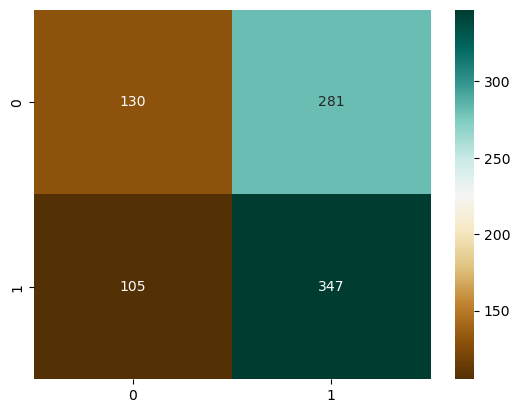

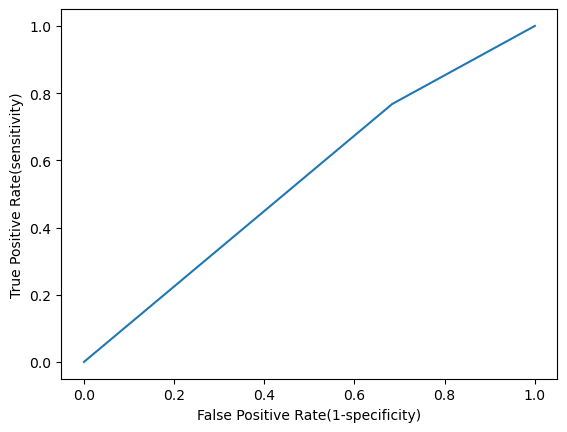

In [27]:
#testing the new model
fit_and_print(p1,new_x_train_trees, y_train, new_x_test_trees, y_test)

The model looks like its overfitting, but i tried some more grid search parameters and it did not change much. There may be still some more room for improvement here. The model has 347 True positives and 105 False positives and that gives it a recall score of 0.77. It was right about 55% of the time for both directions and has a higher sensitivity, meaning it performs better on the positive side. 

# 8. XGBoost

XGBoost is a higly efficient model that is wideley known. It uses gradient boosting and combines a set of 'weak learners'(in our case descision trees). Every next tree prioritizes learning to solve the parts of the problem that the previous tree couldnt solve.

<img src = https://www.researchgate.net/publication/348025909/figure/fig2/AS:1020217916416002@1620250314481/Simplified-structure-of-XGBoost.ppm
svg.png width = "500" height = "500" align='left'>


I am doing the same things for the XGBoost model

In [28]:
feature_selector_xgb = make_feature_selector(x_train, y_train, xgb)

new_x_train_xgb = feature_selector_xgb.transform(x_train)
new_x_test_xgb = feature_selector_xgb.transform(x_test)

print(f"Selected features:")
print(features[feature_selector_xgb.support_])

Selected features:
['rsi6' 'rsi24' 'volume_change_3']


The XGBoost model only selected 3 features out of the 44. It too selected the rsi indicator for the 6 and 24 day period. 

In [29]:
p2 = Pipeline([('Scaler', preprocess_transformer),('model',xgb)])

In [30]:
params = {'model__n_estimators':[50,100,150],
         'model__max_depth':[2,3,5],
          'model__learning_rate':[0.05,0.1,0.2]
         }

grid_search = GridSearchCV(estimator=p2, param_grid=params,scoring='precision',cv=tsp)
grid_search.fit(new_x_train_xgb, y_train)

grid_search.best_score_
grid_search.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 100}

In [31]:
xgb = XGBClassifier(random_state=1,learning_rate=0.1,max_depth=5, n_estimators=100 )
p2 = Pipeline([('Scaler', preprocess_transformer),('model',xgb)])

Training score:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       917
           1       0.80      0.90      0.85      1096

    accuracy                           0.82      2013
   macro avg       0.83      0.82      0.82      2013
weighted avg       0.83      0.82      0.82      2013

Test score:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       411
           1       0.54      0.50      0.52       452

    accuracy                           0.51       863
   macro avg       0.51      0.51      0.51       863
weighted avg       0.51      0.51      0.51       863



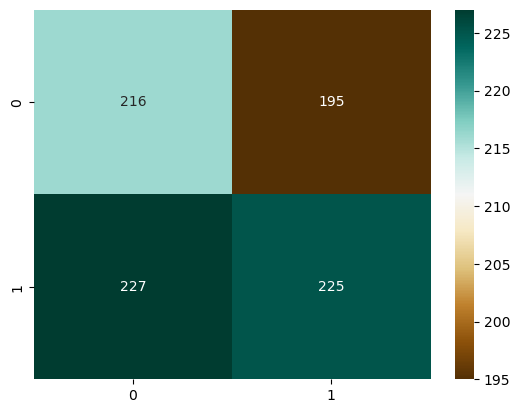

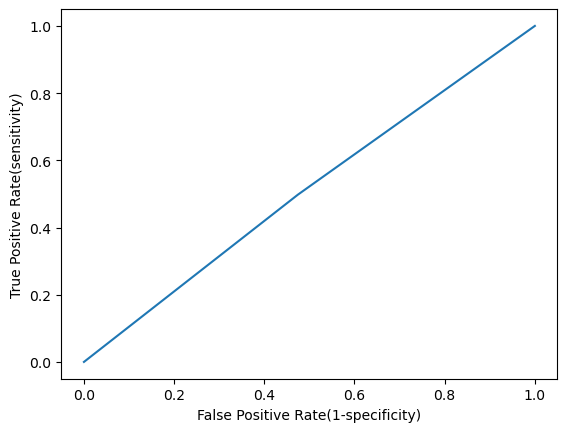

In [32]:
fit_and_print(p2,new_x_train_xgb, y_train, new_x_test_xgb, y_test)

It looks like there is still some overfitting, although not as much as in the ExtraTrees model. There are 225 true positives and 227 true negatives which gives it a recall of 50%, it was right 54% of the time for the positive predictions and 49% of the time for the negative predictions. Since it has a f1 score of practically 51, the roc curve is pretty much flat.

# 9. Extra Tree

'An extremely randomized tree classifier.' - thats coming strainght from the sklearn documentation. It's essentially a descision tree, but when looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

<img src = https://www.researchgate.net/publication/346995264/figure/fig1/AS:969705405812741@1608207193473/The-structure-of-ExtraTree.png
svg.png width = "500" height = "500" align='left'>

Im doing the same thing for the Extra Tree model

In [33]:
feature_selector_e_tree = make_feature_selector(x_train, y_train, e_tree)

new_x_train_e_tree = feature_selector_e_tree.transform(x_train)
new_x_test_e_tree = feature_selector_e_tree.transform(x_test)

print(f"Selected features:")
print(features[feature_selector_e_tree.support_])

Selected features:
['sentiment' 'n_tweets' 'n_tweets_2' 'price_change_1' 'tweets_change_1'
 'volume_change_1' 'tweets_change_3' 'edit_count_change_3'
 'tweets_change_7' 'edit_count_change_7' 'volume_change_7']


The Extra Tree model selected the most amount of features(11 out of 44) and it chose not to use the rsi indicator as a feature. Its also the only model that selected some of the rolling and sentiment features.

In [34]:
p3 = Pipeline([('Scaler', preprocess_transformer),('model',e_tree)])

In [41]:
params = {'model__max_depth':[2,3,5,7,10],
         'model__min_samples_split':[2,3,5,7],
          'model__min_samples_leaf':[1,2,3,5],
          'model__splitter':['random','best']
         }


grid_search = GridSearchCV(estimator=p3, param_grid=params,scoring='precision',cv=tsp)
grid_search.fit(new_x_train_e_tree, y_train)

grid_search.best_params_

{'model__max_depth': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 7,
 'model__splitter': 'best'}

In [36]:
e_tree = ExtraTreeClassifier(random_state=1,max_depth=5,min_samples_leaf=1,min_samples_split=7,splitter='best')
p3 = Pipeline([('Scaler', preprocess_transformer),('model',e_tree)])

Training score:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       917
           1       0.60      0.62      0.61      1096

    accuracy                           0.57      2013
   macro avg       0.57      0.57      0.57      2013
weighted avg       0.57      0.57      0.57      2013

Test score:
              precision    recall  f1-score   support

           0       0.54      0.11      0.18       411
           1       0.53      0.92      0.67       452

    accuracy                           0.53       863
   macro avg       0.54      0.51      0.43       863
weighted avg       0.54      0.53      0.44       863



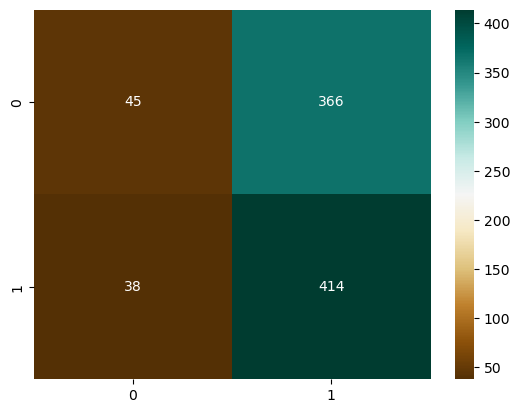

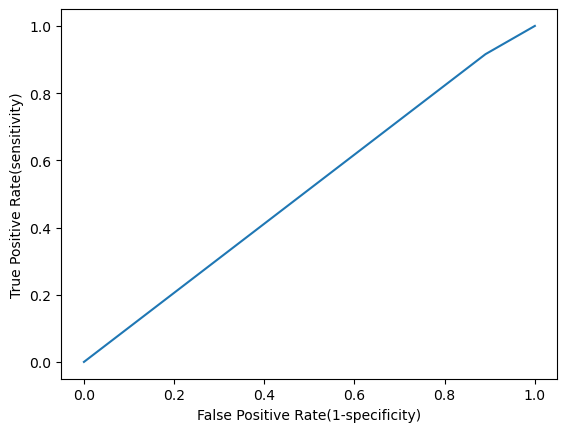

In [37]:
fit_and_print(p3,new_x_train_e_tree, y_train, new_x_test_e_tree, y_test)

We can safely say that there is not much overfitting here. There are 414 true positives and 45 true negatives which gives it a pretty high recall of 92%, it was right 53% of the time for the positive predictions and 54% of the time for the negative predictions. It has a much higher sensitivity, meaning it performs much better on the positive side, we can see that in the recall and f1 score of the negative predictions.

# 10. Combining the models 

Now im going to be combining the predictions of all the models into one. The idea being that if one model is wrong, the other 2 can correct it. Im going to be implementing it by adding the predicted values of all the models and dividing the sum by 3. That way if 2 models vote for 1 and one for 0, the sum devided by 3 is 0.66, after we round it we're going to get 1, which is the majority vote of the three models.

In [38]:
#fitting the models and getting predictions
p1.fit(new_x_train_trees, y_train)
p1_preds = p1.predict(new_x_test_trees)

p2.fit(new_x_train_xgb, y_train)
p2_preds = p2.predict(new_x_test_xgb)

p3.fit(new_x_train_e_tree, y_train)
p3_preds = p3.predict(new_x_test_e_tree)

#making a dataframe
data = {'ExtraTrees':p1_preds,
        'XGBoost':p2_preds,
        'ExtraTree':p3_preds}
preds = pd.DataFrame(data,index=x_test.index)

#making a column for the combined predictions
preds['combined']=(preds['ExtraTrees']+preds['XGBoost']+preds['ExtraTree'])/3
preds['combined']=preds['combined'].astype(int)

In [39]:
#making a test function
def test(preds, real):
    
    print('Test score:')
    print(classification_report(real, preds))
    
    sns.heatmap(confusion_matrix(real, preds),annot=True, cmap='BrBG', fmt='g')
    plt.show()
    
    fpr, tpr, _ = roc_curve(real, preds)
    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate(sensitivity)')
    plt.xlabel('False Positive Rate(1-specificity)')
    plt.show()
    
    print('Benchmark for test data:')
    plt.figure(figsize=(3, 3))
    pie=plt.pie(y_test.value_counts(),autopct='%1.1f%%', labels=['Up','Down'])
    plt.show()
    
    print('Final Score')
    print(precision_score(real, preds))

Test score:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       411
           1       0.57      0.37      0.45       452

    accuracy                           0.52       863
   macro avg       0.53      0.53      0.51       863
weighted avg       0.53      0.52      0.51       863



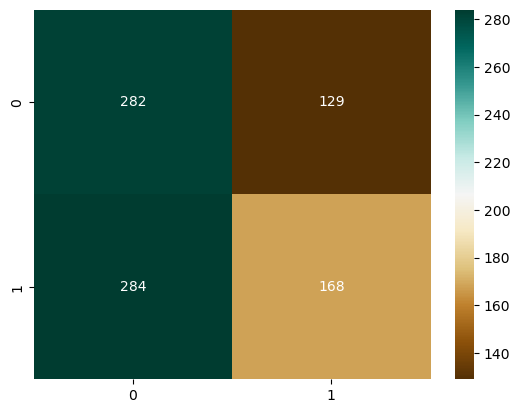

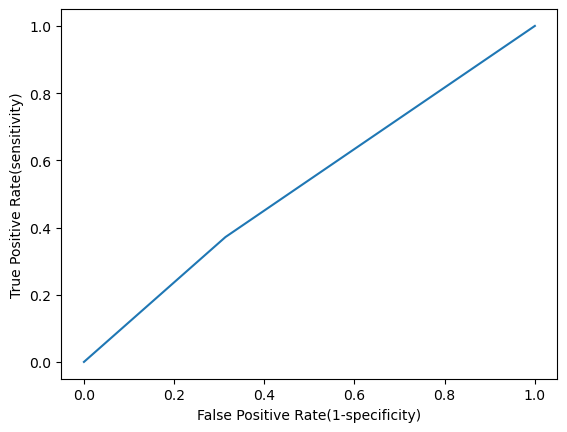

Benchmark for test data:


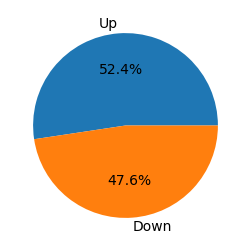

Final Score
0.5656565656565656


In [40]:
test(preds['combined'],y_test)

There are 168 true positives and 282 true negatives which gives our final model a recall score of 92%, it was right 57% of the time for the positive predictions, but only 50% of the time for the negative predictions. It has a much higher specificity, meaning it performs 'better' on the negative side, we can see that in the recall and f1 score of the negative predictions. The price wen up 52.4% of the time in our testing set, so if we were to buy in the begining of every day and sell at the end of every day, we would've been correct 52.4% of the time. The final model was right about 56.6% of the time, although it did make a lot less guesses that the price will go up.

# 11. Further Improvements
1) There is still some room for better hyperparameter tuning.

2) Some of the code (like the feature selection) can be implemented into a PipeLine for better speed and readability.

3) Better Voting system - sklearn's VotingClassifier for example.

4) More data - there is still a lot of room for more data such as on chain data like hashrate and maybe even some sentiment analysis on CNBC news articles.

5) Some more metrics and visualizations (like the prescision-recall curve)

6) Some fixes of sloppy code and typos + some more annotation :) 

# 12. Rescources:
1) DataQuest: https://www.youtube.com/watch?v=TF2Nx_ifmrU (his model managed to only get 53.6% precision, so im really happy with the performance of my model)

2) Divta Yageti's Medium Blog: https://medium.com/coinmonks/forecasting-next-day-btc-prices-using-a-high-dimensional-multivariate-data-cb833ab61183 (gave me the idea for the web scraping of the twitter data)